In [3]:
import firebase_admin
from firebase_admin import firestore
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append(os.path.dirname(os.getcwd() ))

import visualize


In [4]:
cred = firebase_admin.credentials.Certificate('key.json')
default_app = firebase_admin.initialize_app(cred)
db = firestore.client()
instructions_ref = db.collection('instructions')
verify_ref = db.collection('verification')


In [5]:
list_instruction = list(instructions_ref.get())
list_verification = list(verify_ref.get())
len(list_instruction), len(list_verification)

#10404


(10404, 18815)

In [4]:
# instructions_ref_sandbox = db.collection('instructions_sandbox')
# verify_ref_sandbox = db.collection('verification_sandbox')

# list_instruction_sandbox = list(instructions_ref_sandbox.get())
# list_verification_sandbox = list(verify_ref_sandbox.get())
# len(list_instruction_sandbox), len(list_verification_sandbox)

In [4]:
# Qualified workers
current_dir = os.getcwd()
parent_dir = Path(current_dir).parent.absolute()
path_qualified = os.path.join(parent_dir, "qualified_workers.csv")

qualified_work_list = pd.read_csv(path_qualified, header=None)[0].tolist()

qualified_work_list

FileNotFoundError: [Errno 2] No such file or directory: '/home/onlp_gcp_biu/cabby/app/qualified_workers.csv'

In [5]:
# # Takes a long time!!!!  ~10m

# # Set qualified instructions as RVS_excellent  - UPDATES DATA!!!
# qualified_instructions = [
#   e.to_dict()['key'] for e in list_instruction if (
#     e.to_dict()['work_id'] in qualified_work_list) ]

# for id in qualified_instructions:
#   instructions_ref.document(id).update(
#     {'review': 'RVS_excellent'})


In [ ]:
# # Split instructions to train, dev, test sets.
# import json

# instruction_dir = "/mnt/hackney/human_data"

# def save_split(split_name, split_set):

#   split_path = os.path.join(instruction_dir, split_name)
#   if os.path.exists(split_path):
#     os.remove(split_path)
#   with open(split_path, 'a') as outfile:
#     for sample in split_set:
#       json.dump(sample, outfile, default=lambda o: o.__dict__)
#       outfile.write('\n')
#       outfile.flush()

#   print (f"Size of {split_name} set:{len(split_set)} saved to: {split_path}")


# # Save set splits

# dev_ids = ['X']
# test_ids = ['X']


# test_set =  [
#   x.to_dict() for x in list_instruction if 'Manhattan' in x.to_dict()['region'] and x.to_dict()['work_id'] in test_ids]

# save_split("test.json", test_set)

# dev_set =  [
#   x.to_dict() for x in list_instruction if 'Manhattan' in x.to_dict()['region'] and x.to_dict()['work_id'] in dev_ids]

# save_split("dev.json", dev_set)

# train_set = [
#   x.to_dict() for x in list_instruction if 'Manhattan' in x.to_dict()['region'] and x.to_dict()['work_id'] not in dev_ids+test_ids]

# save_split("train.json", train_set)


In [4]:
df_instruction_manhattan = pd.DataFrame(
    [
        x.to_dict() for x in list_instruction if 'Manhattan' in x.to_dict()['region'] ])

df_instruction_pitssburgh = pd.DataFrame(
    [
        x.to_dict() for x in list_instruction if 'Pittsburgh' in x.to_dict()['region'] ])

df_instruction_philadelphia = pd.DataFrame(
    [
        x.to_dict() for x in list_instruction if 'Philadelphia' in x.to_dict()['region'] ])

print (df_instruction_manhattan.shape[0], df_instruction_pitssburgh.shape[0], df_instruction_philadelphia.shape[0])

8103 1023 1278


In [5]:
# check the new workers ID
df_instruction_manhattan = pd.DataFrame(
    [
        x.to_dict() for x in list_instruction if 'Manhattan' in x.to_dict()['region'] and  'date_start' in x.to_dict() and '2022-11-01' <x.to_dict()['date_start'] ])

df_verification = pd.DataFrame(
        [x.to_dict() for x in list_verification] )


df_manhattan = df_instruction_manhattan.merge(df_verification, left_on='key', right_on='key_instruction')

# work_ids = list(set(df_manhattan['work_id_x'].to_list()))


# for work_id in work_ids:
#     if work_id in qualified_work_list:
#         continue
#     sample_worker = df_manhattan[df_manhattan['work_id_x']==work_id]
#     if sample_worker.shape[0]<3:
#         continue
#     sample_worker = sample_worker.sort_values( by=['date_start_x'], ascending=False)
#     print (f"--------{work_id}--------")
#     print (sample_worker[['date_start_x', 'review', 'assignmentId_x','dist_m']])


In [6]:
# Check the stack of RVS_excellent
all_data = pd.DataFrame([x.to_dict() for x in list_instruction ])
x = all_data[all_data['review']=='RVS_excellent' ]
print (f"RVS_excellent: {x[x['verified_n']==0].shape[0]}")
# invalid
invalid = all_data[all_data['valid']==False]
print (f"invalid: {invalid.shape[0]}")

# invalid: 88



RVS_excellent: 0
invalid: 0


In [7]:
# merge instructions with verification
df_instruction = pd.DataFrame([x.to_dict() for x in list_instruction])
df_ver = pd.DataFrame([x.to_dict() for x in list_verification ])

instruction_ver = df_instruction.merge(df_ver, left_on='key', right_on='key_instruction')


In [8]:
# Valid instruction
dist_threshold = 100


manhattan_instruction_ver = instruction_ver[instruction_ver['region']=='Manhattan']
pittsburgh_instruction_ver = instruction_ver[instruction_ver['region']=='Pittsburgh']
philadelphia_instruction_ver = instruction_ver[instruction_ver['region']=='Philadelphia']


all_valid_instructions = instruction_ver[instruction_ver['dist_m']<dist_threshold]
manhattan_valid_instructions = all_valid_instructions[all_valid_instructions['region']=='Manhattan']
pittsburgh_valid_instructions = all_valid_instructions[all_valid_instructions['region']=='Pittsburgh']
philadelphia_valid_instructions = all_valid_instructions[all_valid_instructions['region']=='Philadelphia']


valid_instructions = all_valid_instructions.groupby('key_instruction').min()
# all_instructions = instruction_ver.groupby('key_x').min()
len_instructions = instruction_ver.drop_duplicates(subset=['key_x']).shape[0]
print (f"All valid for theshold {dist_threshold}: {round(100*valid_instructions.shape[0]/len_instructions, 3)}" )


manhattan_valid_instructions = manhattan_valid_instructions.groupby('key_instruction').min()
len_manhattan_instructions = manhattan_instruction_ver.drop_duplicates(subset=['key_x']).shape[0]
print (f"Manhattan valid for theshold {dist_threshold}: {round(100*manhattan_valid_instructions.shape[0]/len_manhattan_instructions, 3)}" )

pittsburgh_valid_instructions = pittsburgh_valid_instructions.groupby('key_instruction').min()
len_pittsburgh_instructions = pittsburgh_instruction_ver.drop_duplicates(subset=['key_x']).shape[0]
print (f"Pittsburgh valid for theshold {dist_threshold}: {round(100*pittsburgh_valid_instructions.shape[0]/len_pittsburgh_instructions, 3)}" )


philadelphia_valid_instructions = philadelphia_valid_instructions.groupby('key_instruction').min()
len_philadelphia_instructions = philadelphia_instruction_ver.drop_duplicates(subset=['key_x']).shape[0]
print (f"Philadelphia valid for theshold {dist_threshold}: {round(100*philadelphia_valid_instructions.shape[0]/len_philadelphia_instructions, 3)}" )


# All valid for theshold 100: 98.286
# Manhattan valid for theshold 100: 98.6
# Pittsburgh valid for theshold 100: 95.797
# Philadelphia valid for theshold 100: 100.0




All valid for theshold 100: 100.0
Manhattan valid for theshold 100: 100.0
Pittsburgh valid for theshold 100: 100.0
Philadelphia valid for theshold 100: 100.0


In [11]:
print (f"Manhttan-set: {manhattan_valid_instructions.shape[0]}")
print (f"Pittsburgh-set: {pittsburgh_valid_instructions.shape[0]}")
print (f"Philadelphia-set: {philadelphia_valid_instructions.shape[0]}")

Manhttan-set: 8103
Pittsburgh-set: 1023
Philadelphia-set: 1278


In [12]:
# status of colection

print (f"size of Manhattan-set: {len_manhattan_instructions}")
print (f"size of Pittsburgh-set: {len_pittsburgh_instructions}")
print (f"size of Philadelphia-set: {len_philadelphia_instructions}")

size of Manhattan-set: 8103
size of Pittsburgh-set: 1023
size of Philadelphia-set: 1278


In [12]:
# # assure all points are of the same format  - UPDATES DATA!!!
# import math
# import util

# list_instruction_all_x = [x.to_dict() for x in list_instruction]
# for sample in list_instruction_all_x: 
#   for key, point in sample.items():
#     FLAG_prob = False
#     if not 'point' in key:
#       continue
      

#     if isinstance(point, list):
#       if not(isinstance(point[0], float) and isinstance(point[1], float)):
#         FLAG_prob = True
#       y = float(point[0])
#       x = float(point[1])
#       point = [y ,x]
#     else:
#       FLAG_prob = True
#       point = util.point_from_str_point(point)
#       y = point.y
#       x = point.x
#       point = [y, x]
#       if not (y>40 and x<-73):
#         if x>40 and y<-73:
#           point = [x, y]

#     assert isinstance(y, float) and isinstance(x, float), print (type(y), type(x))
#     assert (isinstance(point, list) and point[0]>40 and point[1]<-73), print(point )

#     id = sample['key']
#     # instructions_ref.document(id).update(
#     #       {key: point})
#     if FLAG_prob:
#       print (f"Writng task PROB with {key}: {sample['key']} ")


# # verify 
# list_verification_x = [x.to_dict() for x in list_verification]
# for sample in list_verification_x: 
#   for key, point in sample.items():
#     FLAG_prob = False
#     if not 'point' in key:
#       continue
    
#     if isinstance(point, list):
#       if isinstance(point[0], float) and isinstance(point[1], float):
#         if (isinstance(point, list) and point[0]>40 and point[1]<-73):
#           continue
#         else:
#           FLAG_prob = True
#       else:
#         FLAG_prob = True
#       y = float(point[0])
#       x = float(point[1])
#       point = [y ,x]
#     else:
#       FLAG_prob = True
#       point = util.point_from_str_point(point)
#       y = point.y
#       x = point.x
#       point = [y, x]
#       if not (y>40 and x<-73):
#         if x>40 and y<-73:
#           point = [x, y]

#     assert isinstance(y, float) and isinstance(x, float), print (type(y), type(x))
#     assert (isinstance(point, list) and point[0]>40 and point[1]<-73), print(f"point: {point} key: {sample['key']}")
    
#     if 'key' not in sample:
#       print (sample['assignmentId'])
#       continue
    
#     if FLAG_prob:
#       print (f"Verify PROB with {key}: {sample['key']} ")
#       id = sample['key']
#       # verify_ref.document(id).update(
#       #       {key: point})

    

In [13]:
import util
import math

# UPDATE!!!
content = "marked in red"

# Check all distances are correct 
for i in range(0,instruction_ver.shape[0]):
  sample = instruction_ver.iloc[i]
  if sample['rvs_goal_point_y']!=sample['rvs_goal_point_x']:
    point_goal_y = util.point_from_list_coord_yx(sample['rvs_goal_point_y'])
    point_goal_x = util.point_from_list_coord_yx(sample['rvs_goal_point_x'])
    dist = round(util.get_distance_between_points(point_goal_y, point_goal_x))
    if dist>1:
      print (f"goal point - key: {sample['key_x']}| {sample['rvs_goal_point_x']}!= {sample['rvs_goal_point_y']}")
      id = sample['key_y']
      verify_ref.document(id).update(
          {'rvs_goal_point': sample['rvs_goal_point_x']})
    
    if not isinstance(sample['rvs_goal_point_y'], list) and math.isnan(sample['rvs_goal_point_y']): 
      id = sample['key_y']
      # verify_ref.document(id).update(
      #     {'rvs_goal_point': sample['rvs_goal_point_x']})

 
  if sample['rvs_start_point_x']!=sample['rvs_start_point_y']:
    point_start_y = util.point_from_list_coord_yx(sample['rvs_start_point_y'])
    point_start_x = util.point_from_list_coord_yx(sample['rvs_start_point_x'])

    dist = round(util.get_distance_between_points(point_start_y, point_start_x))

    if dist==0:
      continue
    print (f"start point - key: {sample['key_x']}| {sample['rvs_start_point_x']}!= {sample['rvs_start_point_y']}")

    print (f"dist: {dist}")
    id = sample['key_y']
    verify_ref.document(id).update(
    {'rvs_start_point': sample['rvs_start_point_x']})


list_instruction_all_x = [x.to_dict() for x in list_instruction]
dict_col = {'assignmentId': str, 'content': str, 'date_finish': str, 'date_start': str, 'hit_id': str, 
'work_id': str, 'rvs_sample_number': str, 'rvs_path': str, 'rvs_goal_point': list, 'rvs_start_point': list, 
'task': int, 'key': str, 'valid': bool, 'verified_n': int, 'region': str, 'review': str}
should_be_coulmns = set(dict_col.keys())

for sample in list_instruction_all_x: 
  keys = set(sample.keys())
  difference = keys.difference(should_be_coulmns)
  if len(difference)>0:
    if len(difference)==1 and 'review' in difference:
      continue
    print (difference)
  if content in sample['content']:
    print (sample)

  for key, value in sample.items():
    if not isinstance(value, dict_col[key]):
      print (f"key: {key}. value: {value} {type(value)}")


  
# calc distance

list_verification_x = [x.to_dict() for x in list_verification]
print (list_verification_x[0].keys())
for sample in list_verification_x: 
  prediction = util.point_from_list_coord_yx(sample['predict_goal_point'])
  if 'rvs_goal_point' not in sample:
    if 'key_instruction' in sample:
      rvs_goal_point = df_instruction[df_instruction['key_x']==sample['key_instruction']]['rvs_goal_point_x']
      print ("rvs_goal_point: ", rvs_goal_point)
    else:
      found_matches = df_instruction[
        (
          df_instruction['rvs_path']==str(sample['rvs_path'])) & (
            df_instruction['rvs_sample_number']==str(sample['rvs_sample_number']))]
      assert found_matches.shape[0] <= 1, print(found_matches.shape[0])
      if found_matches.shape[0]==0:
        print (f"No such instruction: {sample['assignmentId']}| {sample['rvs_sample_number']}")
      else:
        print (f"one connection: {found_matches['key'].iloc[0]}")
        id = sample['key']
        # verify_ref.document(id).update(
        #   {'key_instruction': found_matches['key'].iloc[0]})


      
    # print (f"NO rvs_goal_point. \n assignmentId: {sample['assignmentId']}")
    continue 
  point_goal = util.point_from_list_coord_yx(sample['rvs_goal_point'])

  dist_true = round(util.get_distance_between_points(prediction, point_goal))
  if 'dist_m' not in sample:
    print (f"No dist_m. \n assignmentId: {sample['assignmentId']}")
    id = sample['key']
    # verify_ref.document(id).update(
    #       {'dist_m': dist_true})
    continue
  dist_m = sample['dist_m']

  if dist_true != dist_m:
    print (f"dist_true: {dist_true} | dist_m: {dist_m}")
    id = sample['key']
    verify_ref.document(id).update(
          {'dist_m': dist_true})



dict_keys(['rvs_sample_number', 'key', 'rvs_goal_point', 'predict_goal_point', 'key_instruction', 'work_id', 'task', 'assignmentId', 'hit_id', 'date_start', 'dist_m', 'rvs_path', 'date_finish', 'rvs_start_point'])


In [13]:
# Takes a long time ~10m
# Check verified_n

for index, sample in instruction_ver.iterrows():
  written_verified_n = sample['verified_n']
  key = sample['key_x']
  true_verified_n = instruction_ver[instruction_ver['key_instruction']==key].shape[0]
  if written_verified_n!=true_verified_n:
    print (f"written_verified_n:{written_verified_n}, true_verified_n:{true_verified_n}")
    instructions_ref.document(key).update(
          {'verified_n': true_verified_n})

In [ ]:

# # Check incorrect instructions

# def get_end_point_tag(row):
#   path_geodata = row['rvs_path_x']
#   sample_n = int(row['rvs_sample_number_x'])
#   final_path_geodata = os.path.join(parent_dir, path_geodata.replace("/app_instructor/", ""))
#   _, _, _, entity, _ = visualize.get_maps_and_instructions(path=final_path_geodata, specific_sample=sample_n)[0]

#   main_tag = entity.geo_landmarks['end_point'].main_tag

  
#   return main_tag in row['content']

# invalid = instruction_ver[instruction_ver['valid_x']==False]
# invalid_verified = invalid[invalid['verified_n']==0]   

# invalid_verified['is_landmarks']  = invalid_verified.apply(get_end_point_tag, axis=1)

# invalid_verified_end_point_not_mentioned = invalid_verified[invalid_verified['is_landmarks']==False]

# print (invalid_verified_end_point_not_mentioned.shape)





In [ ]:
# for i in set(invalid_verified_end_point_not_mentioned[invalid_verified_end_point_not_mentioned['dist_m']<200]['key_x'].tolist()):
#     print (i)

In [ ]:
# # Check incorrect instructions 2


# invalid = instruction_ver[instruction_ver['valid_x']==False]
# invalid_under = invalid[invalid['dist_m']<=2000]   

# set_invalid_under = set(invalid_under[invalid_under['dist_m']>1000]['key_x'].tolist())
# print (len(set_invalid_under))

# for i in set_invalid_under:
#     print (i)


In [ ]:
# # Takes a long time!!!!
# for sample in list_instruction_all_x:
    
#   path_data = sample['rvs_path'].replace("/app_instructor/", "")

#   current_dir = os.getcwd()
#   parent_dir = Path(current_dir).parent.absolute()
#   path_instructions = os.path.join(parent_dir, path_data)
   
#   entities = util.load_entities(path_instructions)
#   assert len(entities)>0, print (sample)


In [ ]:
# # Takes a long time!!!!

# # Check unique points in Manhattan
# # 2854 4583

# import json
# import pathlib 
# from collections import Counter


# def add_osmid(row):
#   path_geodata = row['rvs_path_x']
#   sample_n = int(row['rvs_sample_number_x'])
#   final_path_geodata = os.path.join(parent_dir, path_geodata.replace("/app_instructor/", ""))
#   _, _, _, entity, _ = visualize.get_maps_and_instructions(path=final_path_geodata, specific_sample=sample_n)[0]
#   goal_osmid = entity.geo_landmarks['end_point'].osmid
#   start_osmid = entity.geo_landmarks['start_point'].osmid

#   return str(goal_osmid) + str(start_osmid)
    

# manhattan_instruction_ver['goal__start_osmid']  = manhattan_instruction_ver.apply(add_osmid, axis=1, result_type='expand')


# points = {}
# def first(row):
#   rvs_goal_point_x = row['rvs_goal_point_x']
#   rvs_start_point_x = row['rvs_start_point_x']

#   point = str(rvs_goal_point_x) + str(rvs_start_point_x)
#   if point not in points:
#         points[point]=1
#   else:
#       points[point]+=1

# manhattan_instruction_ver.apply(first, axis=1) #.groupby(['rvs_goal_point_x', 'rvs_start_point_x']).first()
# print (len(points), manhattan_instruction_ver.shape[0])

# counter = {}
# for k, v in points.items():
#     if v not in counter:
#         counter[v] = 1
#     else:
#         counter[v] += 1

# counter_sorted = sorted(counter.items(), key=lambda x:x[0])
# print (counter_sorted)




# unique_osmids = manhattan_instruction_ver['goal__start_osmid'].tolist()
# counter_osmids = Counter(unique_osmids)

# print (f"found {len(counter_osmids)} unique paths")
# path = pathlib.Path().resolve().parent.parent / "cabby/geo/unique_osmids.json"
# with open(path, 'w') as fp:
#     json.dump(counter_osmids, fp)



In [ ]:

# all_valid_instructions_with_flase_validation = all_valid_instructions[all_valid_instructions['valid_x']==False]
# #Update valid instructions
# valid_instructions_tmp = [
#   e.to_dict()['key'] for e in list_instruction if (
#    e.to_dict()['key'] in all_valid_instructions_with_flase_validation['key_x'].tolist()) ]

# print(len(valid_instructions_tmp))
# for id in valid_instructions_tmp:
#   instructions_ref.document(id).update(
#     {'valid': True})

In [14]:

# all_valid_instructions_with_flase_validation = all_valid_instructions[all_valid_instructions['valid_x']==False]
# #Update valid instructions
# valid_instructions_tmp = [
#   e.to_dict()['key'] for e in list_instruction if (
#    e.to_dict()['key'] in all_valid_instructions_with_flase_validation['key_x'].tolist()) ]

# print(len(valid_instructions_tmp))
# for id in valid_instructions_tmp:
#   instructions_ref.document(id).update(
#     {'valid': True})

10391


In [44]:
# current_un_valid = f'manhattan_samples_v80.gpkg'
# all_instruction_to_make_unvalid = all_valid_instructions[
#     all_valid_instructions.rvs_path_x.str.contains(current_un_valid)]
# if all_instruction_to_make_unvalid.shape[0]>0:
#   print (all_instruction_to_make_unvalid.shape)

# #Update valid instructions
# valid_instructions_tmp = [
#   e.to_dict()['key'] for e in list_instruction if (
#    e.to_dict()['key'] in all_instruction_to_make_unvalid['key_x'].tolist()) ]

# print(len(valid_instructions_tmp))
# for id in valid_instructions_tmp:
#   instructions_ref.document(id).update(
#     {'valid': False})

(86, 32)
79


In [14]:
# #How much was not verified at all
# print("verified_n==0 ", df_instruction[df_instruction['verified_n']==0].shape[0])
# print("valid==Flase ", df_instruction[df_instruction['valid']==False].shape[0])

# # verified_n==0  184
# # valid==Flase  710

verified_n==0  0
valid==Flase  0


In [15]:
# keys_to_delete = instruction_ver[instruction_ver['dist_m']>3000].key_y.tolist()

# print (len(keys_to_delete))
# # for id in keys_to_delete:
# #   verify_ref.document(id).delete()
# #   print(id)



0


In [16]:
# keys_add = []

# for k in df_ver.key_instruction.tolist():
#     if df_instruction[df_instruction['key']==k].shape[0]==0:
#         keys_add.append(k)

# print (len(keys_add))
# print (keys_add)

0
[]


In [ ]:
# # Check number of completed assignments per HIT

# hit_id = "A2WX434EAQOE293EQVJH0T40MC0C87AOL51STM3H3TH93"
# assignments = [
#   e.to_dict()['key'] for e in list_instruction if (
#    e.to_dict()['hit_id']==hit_id) ]

# print(f"number of assignments for hit id {hit_id}: {len(assignments)}")


In [22]:
# visualize geosample with instruction by key

instruction = df_instruction[df_instruction['key']=='A2WX434EAQOE293H5TOKO3D9KCM290Z4TTWTS4D8V64L2'].iloc[0]
path_geodata = instruction['rvs_path']
sample_n = int(instruction['rvs_sample_number'])
final_path_geodata = os.path.join(parent_dir, path_geodata.replace("/app_instructor/", ""))
map_osm, _, _, _, _ = visualize.get_maps_and_instructions(path=final_path_geodata, specific_sample=sample_n, with_path=False)[0]
print (instruction['content'])
map_osm


Meet me at a clothes shop north of you on Columbus Avenue. Kiehl's is on the same street to the south of the shop. Club Monaco and a Mexican restaurant are north of the clothes shop. 


In [35]:
# visualize geosample with instruction by worker id (last instruction)

instruction = df_instruction[df_instruction['work_id']=='A1198W1SPF1R4'].sort_values(
    by=['date_finish'], ascending=False).iloc[1]
print (instruction)
path_geodata = instruction['rvs_path']
sample_n = int(instruction['rvs_sample_number'])
final_path_geodata = os.path.join(parent_dir, path_geodata.replace("/app_instructor/", ""))
map_osm, _, _, _, _ = visualize.get_maps_and_instructions(path=final_path_geodata, specific_sample=sample_n, with_path=False)[0]
print (instruction['content'])
map_osm

rvs_sample_number                                                  398
content              Meet me on the south of you at the dry cleanin...
rvs_path               /app_instructor/data/manhattan_samples_v98.gpkg
review                                                             NaN
key                       A1198W1SPF1R43XJOUITW8USPD57ATE8ZA6LNUI9TQ73
rvs_goal_point                               [40.7421306, -73.9795839]
verified_n                                                           1
work_id                                                  A1198W1SPF1R4
region                                                       Manhattan
valid                                                             True
hit_id                                  3XJOUITW8USPD57ATE8ZA6LNUI9TQ7
rvs_start_point                              [40.7551028, -73.9799621]
task                                                               3.0
assignmentId                            3ZY8KE4ISJ47CH9TOBDGZ750EMYQV5
date_s

In [15]:
# Map error

voc = ['map', 'error', 'invalid']
condition = df_instruction['content'].str.contains('|'.join(voc)) 

instruction = df_instruction[condition]
instruction[['key', 'content']]



,key,content
6671,A5WWHKD82I8UE31YWE12TE0DMO4BF2P0QZIPY1317XV3,Meet me at the parking space off of 20th Stree...
6860,A5WWHKD82I8UE3HA5ODM5KATG3DQCQDXJ6OO9881VS23,Meet meet at the waste basket just off 5th Ave...
6976,A5WWHKD82I8UE3PKJ68EHDNXIM9C2YU71ZM6D5SUHJ03,Meet me at the bench at the waters edge almost...
6997,A5WWHKD82I8UE3R16PJFTS3SJLHUP18NU6CXMFC8K4G3,Meet me at the bench on the western shore line...
7038,A5WWHKD82I8UE3ULIZ0H1VA6ZBZC3730M6P715LN51O3,Meet me at the recycling container just off of...
7039,A5WWHKD82I8UE3UOMW19E6D7JY2M1N0P6NLQSA1NC5X3,Meet me at the restaurant on the west side of ...
7083,A5WWHKD82I8UE3XU9MCX6VODV57SXNED3E9M2P7F2R13,Meet me at the bar inside New York Penn Statio...
7341,ALYR5CI2SM2JC3BVS8WK9Q0WC0LPAGKC51AOFX4LIB23,Meet me at the toilets on the west side of Nor...
7362,ALYR5CI2SM2JC3DW3BNF1GHJYKTB3CFREPXO8XWSV813,Meet me at the greengrocer shop on Prince Stre...
7510,ALYR5CI2SM2JC3MZ3TAMYTLOZGS6ZCHYV1PTJFOVRIR3,Meet me at the sushi restaurant on the west si...


In [1]:
import os
import openai
openai.api_type = "azure"
openai.api_base = 'https://biu-oai-test.openai.azure.com/'
openai.api_version = "2023-03-15-preview"
openai.api_key = '4e687f8cfb5049fa9de8f6d0a061d9ad' 


def get_entities_chatGPT(instruction):
  try:
    message = 'Find all landmarks, shops, amenities and street names in the following sentence:\n'+instruction

    response = openai.ChatCompletion.create(
        engine="chatgpt", # engine = "deployment_name".
        messages=[
            # {"role": "system", "content": "You are a helpful assistant."},
            {"role": "user", "content": message},
            # {"role": "assistant", "content": "Yes, customer managed keys are supported by Azure OpenAI."},
            # {"role": "user", "content": "Do other Azure Cognitive Services support this too?"}
        ]
    )

    # print("!!!!!!")

    # print(response['choices'][0]['message']['content'])

    # print("?????")



    entities_per_type = response['choices'][0]['message']['content'].split('\n')
    list_entities = []
    for e_per_type in entities_per_type:

        if len(e_per_type)>=1 and e_per_type[len(e_per_type)-1]=='.':
          e_per_type=e_per_type[:len(e_per_type)-1]
        entities = e_per_type.split(',')
        for e in entities: 
          if ('mentioned' not in e.lower() and 'none' not in e.lower() and 'n/a' not in e.lower()) and e:
              e = e.strip()
              e = e.replace('Landmarks:', '').replace('Street names:', '').replace('Street Names:', '')
              e = e.replace('Shops and Amenities:', '').replace('Shops and amenities:', '')
              e = e.replace('Amenities:', '').replace('Amenity:', '').replace('Shops/amenities:', '')
              e = e.replace('Shops:', '').replace('Shops', '').replace('Landmark:', '')
              if len(e)<=2:
                continue

              list_entities.append(e.strip())

    print(set(list_entities))

    # print("!!!!!!")

  except:
     list_entities = []
  return set(list_entities)#','.join(list_entities)



In [4]:
get_entities_chatGPT("Go to the Shop on the corner")

set()

In [27]:

# # Set qualified instructions as RVS_excellent  - UPDATES DATA!!!

for index, row in df_instruction.iterrows():
  path_rvs = os.path.abspath(row['rvs_path'].replace('/app_instructor/data/', '/data/geodata/'))
  
  print(path_rvs)
  if not os.path.exists(path_rvs):
    print(path_rvs)
  # instructions_ref.document(id).update(
  #   {'rvs_path': 'RVS_excellent'})

/data/geodata/manhattan_samples_v13.gpkg
/data/geodata/manhattan_samples_v13.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v57.gpkg
/data/geodata/manhattan_samples_v57.gpkg
/data/geodata/manhattan_samples_v57.gpkg
/data/geodata/manhattan_samples_v57.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v57.gpkg
/data/geodata/manhattan_samples_v57.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/manhattan_samples_v58.gpkg
/data/geodata/ma

In [20]:

# Takes a long time!!!!  ~20m

# Save instructions to data/human


current_dir = os.getcwd()
parent_dir = Path(current_dir).parent.absolute()
path_instructions = os.path.join(parent_dir, "data/human/instructions.json")


visualizae_map  = {}

set_paths = all_data['rvs_path'].drop_duplicates()

for path_geodata in set_paths:
  final_path_geodata = os.path.join(parent_dir, path_geodata.replace("/app_instructor/", ""))
  print(parent_dir, path_geodata.replace("/app_instructor/", ""))
  visualizae_map[path_geodata] = util.load_entities(final_path_geodata)


def add_landmarks(row):
  path_geodata = row['rvs_path']
  sample_n = int(row['rvs_sample_number'])
  entity = visualizae_map[path_geodata][sample_n]

  landmarks = {l_t:[util.list_yx_from_point(l.geometry), l.main_tag]  for l_t, l in entity.geo_landmarks.items() if l.geometry}
  return landmarks

print ("start going over data")  

data_to_save = all_data
data_to_save['landmarks']  = data_to_save.apply(add_landmarks, axis=1)
data_to_save['landmarks_chatGPT']  = data_to_save.content.apply(get_entities_chatGPT)



# Save instructions to data/human

instuction_col_del = ["work_id", "hit_id", "assignmentId", "date_start", "date_finish", "review"]
data_to_save.drop(instuction_col_del, axis=1).to_json(path_instructions, lines=True, orient='records')
print (f"{data_to_save.shape[0]} instructions saved => {path_instructions}")

# Save verifications to data/human
current_dir = os.getcwd()
parent_dir = Path(current_dir).parent.absolute()
path_verification = os.path.join(parent_dir, "data/human/verification.json")

verification_col_del = ["work_id", "hit_id", "assignmentId", "date_start", "date_finish", "valid"]
df_verification.drop(verification_col_del, axis=1).to_json(path_verification, lines=True, orient='records')
print (f"{df_verification.shape[0]} verifications saved => {path_verification}")


/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v13.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v58.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v57.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app /home/onlp_gcp_biu/tzuf/cabby/app/data/philadelphia_samples_v5.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v27.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v66.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/philadelphia_samples_v10.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/philadelphia_samples_v11.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v25.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/philadelphia_samples_v20.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v70.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v109.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/manhattan_samples_v79.gpkg
/home/onlp_gcp_biu/tzuf/cabby/app data/pittsburgh_samples_v2.gpkg
/home/onlp_gcp_biu/tzuf/cabby/

IndexError: list index out of range

In [98]:
# def fix_landmarks_chatGPT(entities):
#     new_entities = []
#     for e in entities:
#       if ('not mentioned' in e.lower() or 'none' in e.lower() or 'n/a' in e.lower()):
#          continue
#       e = e.replace('Shops and Amenities:', '').replace('Shops and amenities:', '')
#       e = e.replace('Amenities:', '').replace('Amenity:', '').replace('Shops/amenities:', '')
#       e = e.replace('Shops:', '').replace('Shops', '').replace('Landmark:', '').replace('Street Name:', '')
#       e = e.split(':')
#       if len(e)>2:
#          print(e)
#       e=e[-1]
#       e = e.strip('-').strip('/')
#       e = e.strip()

#       if ':' in e:
#          print(e)

#       new_entities.append(e)
    
#     # print(set(new_entities))

#     return set(new_entities)

# landmarks_chatGPT = data_to_save['landmarks_chatGPT'].apply(fix_landmarks_chatGPT)
# data_to_save['landmarks_chatGPT'] = landmarks_chatGPT


# instuction_col_del = ["work_id", "hit_id", "assignmentId", "date_start", "date_finish", "review"]
# data_to_save.drop(instuction_col_del, axis=1).to_json(path_instructions, lines=True, orient='records')
# print (f"{data_to_save.shape[0]} instructions saved => {path_instructions}")

10404 instructions saved => /home/onlp_gcp_biu/tzuf/cabby/app/data/human/instructions.json


In [103]:
from statistics import mean, median

num_entities = landmarks_chatGPT.apply(lambda x: len(x)).tolist()
print (f"Max number of entities: {max(num_entities)}")
print (f"Mean number of entities: {mean(num_entities)}")
print (f"Median number of entities: {median(num_entities)}")
print (f"Min number of entities: {min(num_entities)}")


Max number entities: 17
Mean number entities: 3.9770280661284123
Median number entities: 4.0
Min number entities: 0


In [18]:
# Split valid sets
from sklearn.utils import shuffle
from pathlib import Path


size_train = 7000

def get_landmarks2(df):
    # if 'landmarks' in df:
    #     return df
    if 'rvs_path' not in df:
        df = df.rename(
            columns={
                "rvs_path_x": "rvs_path", 
                'rvs_sample_number_x': 'rvs_sample_number', 
                'key_x': 'key',
                'rvs_goal_point_x': 'rvs_goal_point',
                'rvs_start_point_x': 'rvs_start_point'
                })

    instuction_col = [
        "rvs_sample_number", "content", "rvs_path", "key", 
        "rvs_goal_point", "region", "rvs_start_point"]
    
    df.drop(df.columns.difference(instuction_col), 1, inplace=True)

    df['landmarks'] = df.apply(add_landmarks, axis=1)
    df = df.drop_duplicates(subset=['key'])

    return df


def get_region(df, region):
    df = df[df['region']==region]
    return df

all_valid_instructions = get_landmarks2(all_valid_instructions)
all_valid_instructions = shuffle(all_valid_instructions)

all_valid_instructions_manhattan = get_region(all_valid_instructions, 'Manhattan')
train_set = all_valid_instructions_manhattan[:size_train]
dev_seen_set = all_valid_instructions_manhattan[size_train:]


dev_unseen_set = get_region(all_valid_instructions, 'Pittsburgh')
test_set = get_region(all_valid_instructions, 'Philadelphia')


print(
    f"size of train: {train_set.shape[0]}\nsize of seen dev: {dev_seen_set.shape[0]}\nsize of unseen dev: {dev_unseen_set.shape[0]}\nsize of test set {test_set.shape[0]} ")

parent_dir = os.path.abspath(Path(os.getcwd()).parent)

save_dir = os.path.join(parent_dir, 'data/human/split')

train_path = os.path.join(save_dir, 'train.json')
dev_seen_path = os.path.join(save_dir, 'dev_seen.json')
dev_unseen_path = os.path.join(save_dir, 'dev_unseen.json')
test_path = os.path.join(save_dir, 'test.json')

train_set.to_json(train_path, lines=True, orient='records')
dev_seen_set.to_json(dev_seen_path, lines=True, orient='records')
dev_unseen_set.to_json(dev_unseen_path, lines=True, orient='records')
test_set.to_json(test_path, lines=True, orient='records')

print (f"data saved to to directory => {save_dir}")

/tmp/ipykernel_3278/3142668664.py:25: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  df.drop(df.columns.difference(instuction_col), 1, inplace=True)


size of train: 7000
size of seen dev: 1103
size of unseen dev: 1023
size of test set 1278 
data saved to to directory => /home/onlp_gcp_biu/tzuf/cabby/app/data/human/split


In [6]:
current_dir = os.getcwd()
parent_dir = Path(current_dir).parent.parent.absolute()

train_path = os.path.join(parent_dir, 'dataset/manhattan.json')
dev_seen_path = os.path.join(parent_dir, 'dataset/manhattan_dev.json')
dev_unseen_path = os.path.join(parent_dir, 'dataset/pittsburgh.json')
test_path = os.path.join(parent_dir, 'dataset/philadelphia.json')

train_set = pd.read_json(train_path, lines=True, orient='records')
dev_seen_set = pd.read_json(dev_seen_path, lines=True, orient='records')
dev_unseen_set = pd.read_json(dev_unseen_path, lines=True, orient='records')
test_set = pd.read_json(test_path, lines=True, orient='records')

In [7]:
types_list = {}
for i in range(dev_seen_set.shape[0]):
  type_goal = dev_seen_set.iloc[i].landmarks['end_point'][-1]
  if type_goal in types_list:
    types_list[type_goal] += 1
  else:
    types_list[type_goal] = 1


top_15_types_list = {}
for k,v in types_list.items():
  if v>11:
    print (k, v)
    top_15_types_list[k] = v
print (len(top_15_types_list))
# print (len(types_list))
# print (types_list)
# print (dev_seen_set.shape[0])

cafe 43
bicycle parking 173
bar 25
restaurant 154
bicycle rental 26
fast food restaurant 60
bakery shop 13
clothes shop 35
bench 70
bank 17
post box 16
atm 14
convenience shop 13
garden 39
hotel 17
15


In [8]:
from nltk.tokenize import word_tokenize

instruction_path = '/home/onlp_gcp_biu/cabby/app/data/human/instructions.json'
verification_path = '/home/onlp_gcp_biu/cabby/app/data/human/verification.json'
df_instruction = pd.read_json(instruction_path, lines=True, orient='records')
df_ver = pd.read_json(verification_path, lines=True, orient='records')


instruction_ver = df_instruction.merge(df_ver, left_on='key', right_on='key_instruction')

def get_type_goal(landmark):
    return landmark['end_point'][-1]

instruction_ver['type_goal'] = instruction_ver.landmarks.apply(get_type_goal)

def get_num_entities(landmarks_chatgpt):
    return len(landmarks_chatgpt)

def get_num_tokens(content):

    tokenized_words = word_tokenize(content)
    return len(tokenized_words)


instruction_ver['n_entities'] = instruction_ver.landmarks_chatGPT.apply(get_num_entities)
instruction_ver['n_tokens'] = instruction_ver.content.apply(get_num_tokens)


instruction_ver = instruction_ver.drop(['rvs_sample_number_x', 'rvs_goal_point_x', 'rvs_path_x', 'verified_n', 'valid', 'rvs_start_point_x',
                     'task_x', 'landmarks_chatGPT', 'rvs_sample_number_y', 'key_y', 'rvs_goal_point_y', 'predict_goal_point', 
                     'key_instruction', 'task_y', 'rvs_path_y', 'rvs_start_point_y', 'mismatch', 'landmarks' ], axis=1)



instruction_ver.columns

# instruction_ver = instruction_ver.groupby(['key_x', 'content', 'region', 'type_goal']).aggregate(
#     {'key_x':'min','content':'min', 'region': 'min', 'type_goal': 'min', 'dist_m': 'mean'})

dev_instruction_ver = instruction_ver[instruction_ver['region'].str.contains('|'.join(['Manhattan', 'Pittsburgh']))]

print (dev_instruction_ver.shape)

(17337, 7)


In [38]:
types_list = {}
for i in range(dev_instruction_ver.shape[0]):
  type_goal = dev_instruction_ver.iloc[i].type_goal
  if type_goal in types_list:
    types_list[type_goal] += 1
  else:
    types_list[type_goal] = 1

print (len(types_list))

top_x_types_dict = {}
for k,v in types_list.items():
  # if v>49:
  # if v>280:
  # if v>150:
  if v>0:
    # print (k, v)
    top_x_types_dict[k] = v
print (len(top_x_types_dict))

415
415


In [39]:
top_x_types_list = [k for k,v in top_x_types_dict.items()]
dev_instruction_ver_by_type = dev_instruction_ver[instruction_ver['type_goal'].isin(top_x_types_list)]
# dev_instruction_ver_by_type.shape
# dev_instruction_ver_by_type.iloc[0:10]['type_goal']

/tmp/ipykernel_12168/4239705107.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  dev_instruction_ver_by_type = dev_instruction_ver[instruction_ver['type_goal'].isin(top_x_types_list)]


In [40]:
map_type_idx = {t:idx for idx, t in enumerate(top_x_types_list)}
map_idx_type = {v:k for k,v in map_type_idx.items()}

In [41]:
dev_instruction_ver_by_type['type_goal_idx'] = dev_instruction_ver_by_type.type_goal.apply(
    lambda x: map_type_idx[x])

In [42]:
dev_instruction_ver_by_type.columns

Index(['content', 'key_x', 'region', 'dist_m', 'type_goal', 'n_entities',
       'n_tokens', 'type_goal_idx'],
      dtype='object')

In [46]:
from geopy.distance import great_circle
import collections

path_model = '/home/onlp_gcp_biu/tmp2/metrics.tsv'

EvalDataTuple = collections.namedtuple(
  "EvalDataTuple",
  ["example_id", "true_lat", "true_lng", "predicted_lat", "predicted_lng"])

def get_error_distances(input_file):
  """Compute error distance in meters between true and predicted coordinates.

      Args:
      input_file: TSV file containing example_id and true and
        predicted co-ordinates. One example per line.
      eval_logger: Logger object.

      Returns:
      Array of distance error - one per example.
  """
  error_distances = []
  total_examples = 0
  print(f"Opening file <= {input_file}")
  for line in open(input_file):
    toks = line.strip().split("\t")
    if len(toks) != 7:
      print(
        "Unexpected line format: [%s]. Skipping", line)
      continue
    eval_tuple = EvalDataTuple(toks[0], float(toks[1]), float(toks[2]),
                    float(toks[3]), float(toks[4]))
    err = great_circle((eval_tuple.true_lat, eval_tuple.true_lng),
                (eval_tuple.predicted_lat, eval_tuple.predicted_lng)).m
    error_distances.append(err)
    total_examples += 1
  return error_distances


model_dist = get_error_distances(path_model)
len(model_dist)

Opening file <= /home/onlp_gcp_biu/tmp/metrics.tsv


1278

<function list.index(value, start=0, stop=9223372036854775807, /)>

In [48]:
from scipy.stats import f_oneway
from statsmodels.stats.multitest import fdrcorrection

# top_x_types_list

# f=f_oneway( dev_instruction_ver_by_type['type_goal_idx'], 
#            dev_instruction_ver_by_type['dist_m']
# )
# statistics = f.statistic
# pvalues = f.pvalue



cols = ['dist_m', 'type_goal_idx','n_entities','n_tokens',]
statistics = []
pvalues = []

dev_instruction_ver_by_type_spec = [
    dev_instruction_ver_by_type[dev_instruction_ver_by_type['type_goal']==top_x_types_list[i]] for i in range(len(top_x_types_dict))]

print (len(dev_instruction_ver_by_type_spec))
for col in cols:
    f=f_oneway( *[x[col].dropna()  for x in dev_instruction_ver_by_type_spec])
    statistics.append(f.statistic)
    pvalues.append(f.pvalue)

# cols.append('dist_model')
# f=f_oneway( model_dist)
# statistics.append(f.statistic)
# pvalues.append(f.pvalue)


table_anova=pd.concat([pd.DataFrame(fdrcorrection(pvalues)).T,pd.DataFrame([cols,pvalues]).T],axis=1)
table_anova.columns=['result','fdr','feature','p_value']
table_anova[['feature','p_value','fdr','result']].set_index('feature')

415


/opt/conda/envs/cabby2/lib/python3.8/site-packages/scipy/stats/_stats_py.py:3895: ConstantInputWarning: Each of the input arrays is constant;the F statistic is not defined or infinite
  warnings.warn(stats.ConstantInputWarning(msg))


,p_value,fdr,result
feature,,,
dist_m,0.564799,0.564799,False
type_goal_idx,0.0,0.0,True
n_entities,0.0,0.0,True
n_tokens,0.0,0.0,True


In [15]:
max_distance = 0
max_type = -1

type_dist = {}

for i in range(10):
    current_type = top_x_types_list[i]
    # print (current_type)
    dist = dev_instruction_ver_by_type[dev_instruction_ver_by_type['type_goal']==current_type]['dist_m'].mean()
    type_dist[current_type] = dist
    if max_distance<dist:
        max_distance = dist
        max_type = current_type
    

# print (type_dist)
# print (max_type, max_distance)
# print (min(type_dist, key=type_dist.get))

dict(sorted(type_dist.items(), key=lambda item: item[1]))


{'bar': 48.83373493975903,
 'bank': 50.69908814589666,
 'restaurant': 58.803523035230356,
 'bench': 60.97475570032573,
 'fast food restaurant': 65.2888583218707,
 'bicycle parking': 67.8156575395295,
 'clothes shop': 78.68564356435644,
 'garden': 87.37653631284917,
 'bicycle rental': 91.24260355029585,
 'cafe': 93.66364812419147}

In [17]:
import numpy as np
# landmarks, rvs_sample_number, rvs_path

def add_keys(dataset, start_from=0):
  dataset['key'] = np.arange(dataset.shape[0])+start_from
  return dataset['key'].max()

def remove_map(dataset):
  for c in ['landmarks', 'rvs_sample_number', 'rvs_path']:
    if c in dataset:
      dataset.drop(c, axis =1, inplace=True)


finished_key = add_keys(train_set, 0)
finished_key = add_keys(dev_seen_set, finished_key+1)
finished_key = add_keys(dev_unseen_set, finished_key+1)
finished_key = add_keys(test_set, finished_key+1)
remove_map(test_set)


train_set.to_json(train_path, lines=True, orient='records')
dev_seen_set.to_json(dev_seen_path, lines=True, orient='records')
dev_unseen_set.to_json(dev_unseen_path, lines=True, orient='records')
test_set.to_json(test_path, lines=True, orient='records')

In [12]:
#Data statistics 
from nltk.tokenize import word_tokenize
from statistics import mean, median



# all_tokenized_words = all_valid_instructions.content.apply(word_tokenize)
manhattan_set = pd.concat([train_set, dev_seen_set]) 

manhattan_tokenized_words = manhattan_set.content.apply(word_tokenize)
train_tokenized_words = train_set.content.apply(word_tokenize)
dev_seen_tokenized_words = dev_seen_set.content.apply(word_tokenize)
dev_unseen_tokenized_words = dev_unseen_set.content.apply(word_tokenize)
test_tokenized_words = test_set.content.apply(word_tokenize)

# Avg per sample \ Unique in corpus:
# number of tokens -V
# number of entities -!
# number of preposition -!
# number of verbs -!

# (vocabulary size)

# length of path, max. min

# venn digram over train, dev-seen, dev-unseen

# 

number_tokens_avg_samples = round(mean([len(l) for l in manhattan_tokenized_words.tolist()]), 2)
print(f"number of tokens per sample: {number_tokens_avg_samples}")
number_unique_tokens_corpus = len(set([w for l in manhattan_tokenized_words.tolist() for w in l]))
print(f"size of vocabulary: {number_unique_tokens_corpus}")



number of tokens per sample: 43.79
size of vocabulary: 6365


In [ ]:
# length of path, max. min


def get_route_length(row):
  
  entity = visualizae_map[row.rvs_path][int(row.rvs_sample_number)]
  return round(util.get_linestring_distance(entity.route))


route_length = manhattan_set.apply(get_route_length, axis=1)

max_result = max(route_length.tolist())


min_result = min(route_length.tolist())

mean_result = mean(route_length.tolist())

median_result = median(route_length.tolist())

print (f"max length: {max_result}")
print (f"min length: {min_result}")
print (f"mean length: {mean_result}")
print (f"median length: {median_result}")


In [21]:

def get_osmid(row):
  entity = visualizae_map[row.rvs_path][int(row.rvs_sample_number)]
  return str(entity.geo_landmarks['end_point'])+str(entity.geo_landmarks['start_point'])

osmid = all_data.apply(get_osmid, axis=1)

osmid.drop_duplicates().shape[0], all_data.shape[0]

(9066, 10404)

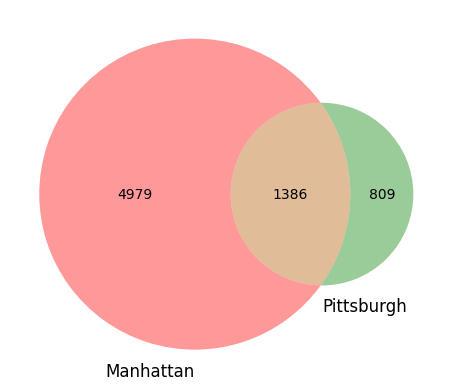

In [15]:
# venn digram over train, dev-seen, dev-unseen

import matplotlib.pyplot as plt
from matplotlib_venn import venn2


# tokenized_words_pittsburgh = pittsburgh_valid_instructions.content.apply(word_tokenize)


# Use the venn2 function
set_train = set([w for l in manhattan_tokenized_words.tolist() for w in l])
# set_dev_seen = set([w for l in dev_unseen_tokenized_words.tolist() for w in l])
set_dev_unseen = set([w for l in dev_unseen_tokenized_words.tolist() for w in l])

venn2([set_train, set_dev_unseen], ('Manhattan', 'Pittsburgh'))
plt.show()

In [45]:
d = set_dev_unseen-set_train
upper_list = []
lower_list = []

for w in d:
    if w[0].isupper():
        # print (w)
        upper_list.append(w)
    else:
        lower_list.append(w)

print (len(upper_list)/len(d))       

0.6847960444993819


In [48]:
from collections import Counter
from itertools import chain

freq_pittsburgh = Counter(chain.from_iterable(dev_unseen_tokenized_words.tolist()))
print (len(freq_pittsburgh))

new_freq_pittsburgh = {}
for w in upper_list:
    if w in freq_pittsburgh:
        new_freq_pittsburgh[w] = freq_pittsburgh[w]
        # print (freq_pittsburgh[w], w)

print (len(new_freq_pittsburgh))
new_freq_pittsburgh = dict(sorted(new_freq_pittsburgh.items(), key=lambda x:x[1], reverse=True))
new_freq_pittsburgh

2195
554


{'Carson': 65,
 'Forbes': 62,
 'Pittsburgh': 54,
 'Allegheny': 29,
 'Smallman': 28,
 'Railroad': 25,
 'Shore': 18,
 'Ohio': 18,
 'Good': 16,
 'Bellefield': 16,
 'Schenley': 15,
 'Spirits': 15,
 'Heinz': 14,
 'Fort': 13,
 'Bruegger': 12,
 'Waterfront': 11,
 'Graeme': 10,
 'Oakland': 10,
 'Baum': 10,
 'Shadyside': 9,
 'Allies': 9,
 'Giant': 8,
 'Academy': 8,
 'Walnut': 8,
 'Brighton': 7,
 'Margaret': 7,
 'UPMC': 7,
 'Morrison': 7,
 'Riverfront': 7,
 'Dairy': 7,
 'Sales': 7,
 'Duquesne': 7,
 'Fruit': 7,
 'Panther': 7,
 'Auction': 7,
 'Queen': 7,
 'Monongahela': 7,
 'Federated': 6,
 'PPG': 6,
 'Aiken': 6,
 'Rooney': 6,
 'Citizens': 6,
 'Clips': 6,
 'Hair': 6,
 'Trail': 6,
 'Eloise': 6,
 'Reedsdale': 6,
 'Meraki': 6,
 'Fourth': 6,
 'Foster': 5,
 'Mellon': 5,
 'Commons': 5,
 'Day': 5,
 'Frew': 5,
 'Fairmont': 5,
 'Lawrence': 5,
 'Rye': 5,
 'LA': 5,
 'Kiefer': 5,
 'Hollow': 5,
 'Stephen': 5,
 'Mercy': 5,
 'Wilson': 5,
 'Jimmy': 5,
 'Shiloh': 4,
 'Knoll': 4,
 'Litchfield': 4,
 'Natural': 4,
 '

In [38]:
footballers_goals = {'Eusebio': 120, 'Cruyff': 104, 'Pele': 150, 'Ronaldo': 132, 'Messi': 125}

sorted_footballers_by_goals = sorted(footballers_goals.items(), key=lambda x:x[1], reverse=True)
converted_dict = dict(sorted_footballers_by_goals)

print(converted_dict)

{'Pele': 150, 'Ronaldo': 132, 'Messi': 125, 'Eusebio': 120, 'Cruyff': 104}
